This mock data uses a fixed global parameter + random draws for the age and theta parameters.

In [1]:
%pylab inline
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
from Chempy.cem_function import single_timestep_chempy
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


First we choose some SSP parameters - set as the TNG values.

In [2]:
from scipy.stats import norm
global_params = np.asarray([-2.3,-2.89])

In [3]:
global_params

array([-2.3 , -2.89])

In [4]:
# Generate random stellar datapoints with these global parameters
N_stars = 1000
times = np.random.uniform(2.,12.8,N_stars)

# Minm SFR constraint
log_SFR_lim = 0.29402

ism_priors = a.p0[2:]
ism_prior_widths = [0.3,0.1,0.1]

ism_params = [np.random.normal(loc=ism_priors[i],scale=ism_prior_widths[i],size=N_stars) for i in range(len(ism_priors))]
ism_params = np.asarray(ism_params).T.reshape(N_stars,len(ism_priors))

from scipy.stats import truncnorm
ism_params[:,1]=truncnorm.rvs((log_SFR_lim-ism_priors[1])/ism_prior_widths[1],np.inf,
                              loc=ism_priors[1],scale=ism_prior_widths[1],size=N_stars)

In [5]:
full_params = np.zeros([len(ism_params),6])
for i in range(len(full_params)):
    full_params[i]=np.asarray(list(global_params)+list(ism_params[i])+[times[i]])

In [6]:
# Now fix relevant elements by running Chempy
out=np.inf
i=0
while out==np.inf:
    out=single_timestep_chempy((full_params[i],a))
    i+=1
_,chempy_els=out

In [7]:
def runner(index):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    output=single_timestep_chempy((full_params[index],b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(chempy_els))
    else: 
        abun=output[0]
        del b;
        outs=abun
    return outs


### Create mock data for 1000 stars

In [8]:
import multiprocessing as mp
import tqdm
p=mp.Pool()
mock_abundances=np.asarray(list(tqdm.tqdm(p.imap(runner,range(len(full_params))),total=len(full_params))))

100%|██████████| 1000/1000 [00:33<00:00, 29.80it/s]


#### these are pre-SFR-normalization change results

In [9]:
param_set=array([-2.3       , -2.89      , -0.28877797,  0.69617338,  0.31947144,
        5.775597  ])
abun_set=array([ 0.10242265, -0.03632165,  0.03632165,  0.0700058 ,  0.28173835,
        0.09692345,  0.58339546,  0.38003772,  0.23129138])
abun_set_v2=array([0.10081202, -0.07849708,  0.07849708,  0.10674589,  0.28134258,
        0.09533509,  0.58249069,  0.38117399,  0.2340569])

In [10]:
c=ModelParameters()
print(single_timestep_chempy((param_set,c)))
del c

(array([ 0.10128596, -0.05943825,  0.05943825,  0.0901672 ,  0.28216482,
        0.0959299 ,  0.5832668 ,  0.38192664,  0.23452604]), ['C', 'Fe', 'H', 'He', 'Mg', 'N', 'Ne', 'O', 'Si'])


## There's clearly some small differences here - especially in H / He

In [12]:
mock_ordered_abundances = np.zeros([len(mock_abundances),len(a.initial_neural_names)])        
for i,el in enumerate(a.initial_neural_names):
    for j,el_chempy in enumerate(chempy_els):
        if str(el)==str(chempy_els[j]):
            mock_ordered_abundances[:,i]=mock_abundances[:,j]
            break
        if j==len(chempy_els)-1:
            print('Element %s not found'%el)
        

In [13]:
good_id=np.where(mock_ordered_abundances[:,0]!=0)
true_abundances=mock_ordered_abundances[good_id]
true_times=times[good_id]
full_params2=full_params[good_id]

In [14]:
len(full_params2)

1000

Now jitter the true values to find mock observations using the correct fractional error.

In [15]:
from scipy.stats import norm

Exclude values with too large / high observational times

In [16]:
pc_ab = 5
pc_time = 20
obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors).round(2)
obs_time_errors = (np.abs(true_times)*float(pc_time)/100.).round(2)
obs_times = norm.rvs(loc=true_times,scale=obs_time_errors).round(2)

filt = np.where((obs_times>1.)&(obs_times<13.8))
obs_ab_errors=obs_ab_errors[filt]
obs_abundances=obs_abundances[filt]
obs_time_errors=obs_time_errors[filt]
obs_times=obs_times[filt]
true_times = true_times[filt]
true_abundances = true_abundances[filt]

np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Chempy_Mock_Data_Full.npz',
         elements = np.asarray(a.initial_neural_names,dtype=str),
         abundances = obs_abundances, abundance_errs = obs_ab_errors,
         true_time = true_times, obs_time = obs_times, obs_time_err = obs_time_errors,
         true_abuns = true_abundances)

### Compare mock data to our TNG galaxy:

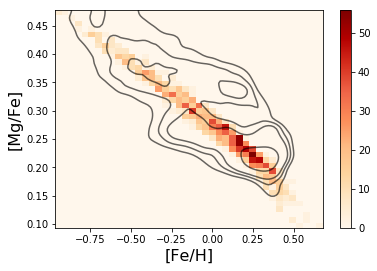

In [17]:
dat=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/TNG_Mock_Data_Full.npz')
all_abuns=dat.f.true_abuns
times=dat.f.true_time
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()

xx=mock_ordered_abundances[:,1]
yy=mock_ordered_abundances[:,3]#+28.*mock_ordered_abundances[:,7])/(16.+28.+24.);
plt.hist2d(xx,yy,cmap=cm.OrRd,normed=True,bins=40)

from corner import hist2d as cohist
x=all_abuns[:,1];y=all_abuns[:,3]#''(16.*all_abuns[:,6]+all_abuns[:,3]*24.+all_abuns[:,7]*28.)/(16.+24.+28.)
cohist(x,y,bins=100,range=[[xx.min(),xx.max()],[yy.min(),yy.max()]],smooth=2.,
       alpha=0.1,plot_density=False,plot_datapoints=False,no_fill_contours=True,contour_kwargs={'alpha':0.6})

plt.ylabel(r'[Mg/Fe]',fontsize=16)
plt.xlabel('[Fe/H]',fontsize=16)
plt.colorbar();#ax.colorbar()
#plt.show()

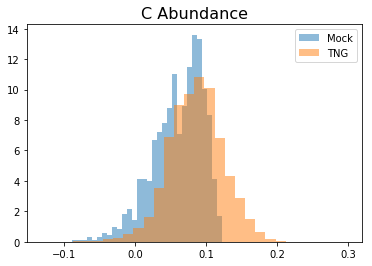

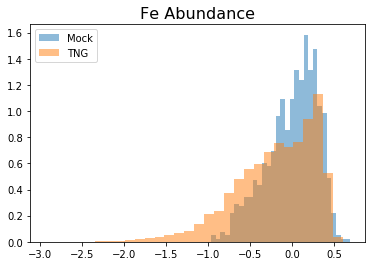

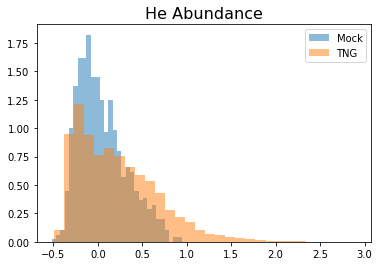

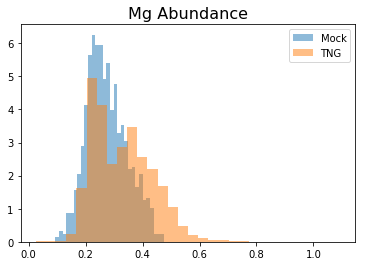

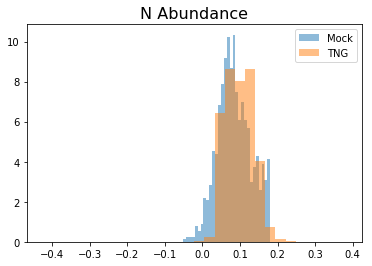

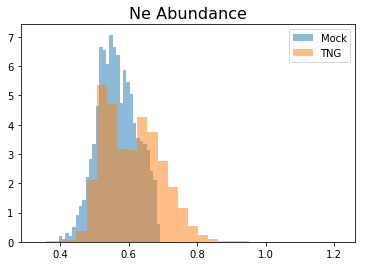

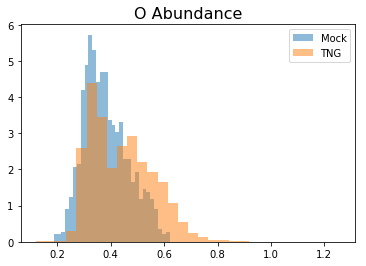

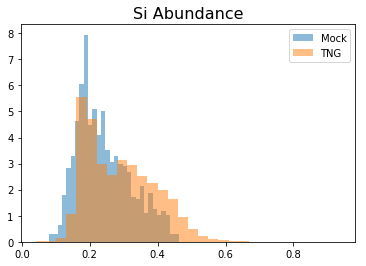

In [18]:
for i in range(len(a.initial_neural_names)):
    plt.figure()
    plt.hist(mock_ordered_abundances[:,i],alpha=0.5,density=True,bins=30,label='Mock')
    plt.hist(all_abuns[:,i],alpha=0.5,density=True,bins=30,label='TNG')
    plt.title('%s Abundance'%a.initial_neural_names[i],fontsize=16);plt.legend()